In [11]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
os.getcwd()
os.chdir("/home/mbilkis/OneDrive/digital-brain/RESEARCH/Sindy/")
from numerics.utilities.misc import *
import matplotlib.pyplot as plt 
from numba import jit
from integration.integrate import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
@jit(nopython=True)
def f(x,t,omega=2.,gamma = 0.1):
    X, Y = x
    return np.array([[-gamma, omega],[-omega,-gamma]]).dot(x)

@jit(nopython=True)
def g(x,t):
    return np.zeros((2,2))

@jit(nopython=True)
def f_cubic(x,t,omega=2.,gamma = 0.1):
    X, Y = x
    return np.array([[-gamma, omega],[-omega,-gamma]]).dot(x**3)

In [13]:
ti,tf,dt = 0,25,0.005
times = np.arange(ti,tf,dt)
x0=np.array([2.,0.])
xx1 = integrate(f,g,x0,times,dt,mode="euler")

/home/mbilkis/OneDrive/digital-brain/RESEARCH/Sindy/learn_torch/integration/steps.py:6: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  return f(x[:,i],t)*dt + g(x[:,i],t).dot(dWs[:,i])


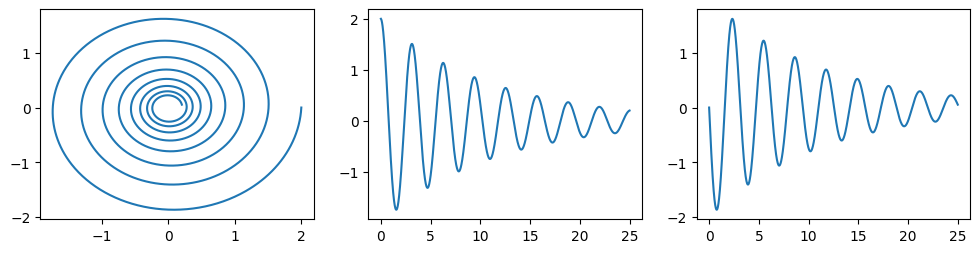

In [14]:
plt.figure(figsize=(12,6))
ax = plt.subplot(231)
ax.plot(xx1[0,:], xx1[1,:])
ax = plt.subplot(232)
ax.plot(times, xx1[0,:])
ax = plt.subplot(233)
ax.plot(times, xx1[1,:])

In [23]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import solve_continuous_are


class GRNN(torch.nn.Module):
    def __init__(self,inputs_cell):
        super(GRNN, self).__init__()
        self.dt = inputs_cell[0]
        omega_f, gamma_f = 2., .1
        initial_data_f = [ [-gamma_f,-omega_f], [omega_f, -gamma_f], [0., 0.], [0., 0.] ] #be careful, A-->A^T here
        self.coeffs_f = torch.nn.Parameter(data = torch.tensor(initial_data_f, dtype=torch.float32,
                                                                      requires_grad = True))
        
        
    def forward(self, dy, state):
        """
        input_data is dy
        hidden_state is x: (<q>, <p>, Var[x], Var[p], Cov(q,q)})
        output dy_hat
        """
        f = state

        dictionary = torch.concatenate([f, f**3])
        
        df = self.dt*dictionary.matmul(self.coeffs_f) ###Check this!
        fnew = f+ df
        
        return fnew, dy

class RecurrentNetwork(torch.nn.Module):
    def __init__(self,inputs_cell):
        super(RecurrentNetwork, self).__init__()
        self.RCell = GRNN(inputs_cell=inputs_cell)
        
    def forward(self, dys):
        dys_hat = []
        xs_hat = [torch.tensor([2., 0.], dtype=torch.float32)]
        x_hat = xs_hat[0]
        for dy_t in dys:
            x_hat, dy_hat = self.RCell(dy_t, x_hat)
            dys_hat += [dy_hat]
            xs_hat += [x_hat]
        return torch.stack(xs_hat), torch.stack(dys_hat)

In [68]:
RNN = RecurrentNetwork(inputs_cell=[dt])

In [69]:
dys = torch.rand(( len(times)-1, 2)).to(torch.device("cpu"))

In [70]:
fs_hat, dys_hat = RNN(dys)

In [71]:
f_true = torch.tensor(xx1.T,dtype=torch.float32)

In [72]:
def lasso_cost(x,f_true,model,alpha=0.01):
    return torch.sum((f_true - model(x)[0])**2) + alpha*torch.sum(torch.abs(model.RCell.coeffs_f))

In [83]:
inputs_cell = [dt]#,  [gamma, omega, n, eta, kappa, b], 3*omega]

RNN = RecurrentNetwork(inputs_cell)

optimizer = torch.optim.Adam(list(RNN.parameters()), lr=1e-2)
dys = torch.rand(( len(times)-1, 2)).to(torch.device("cpu"))
history = {}
history["losses"] = []
history["params"] = []
history["gradients"] = []

for ind in range(50):
    loss = lasso_cost(dys, f_true,RNN, alpha=10.0)
    loss.backward()
    
    optimizer.step()
    history["losses"].append(loss.item())
    history["params"].append(RNN.RCell.coeffs_f.detach().numpy())
    history["gradients"].append(RNN.RCell.coeffs_f.grad.numpy())
    
    print(loss.item())
    
    optimizer.zero_grad()

42.0
51.28484344482422
153.617919921875
49.31930923461914
80.46648406982422
114.4300308227539
107.05978393554688
77.47463989257812
54.566471099853516
57.69761657714844
76.42630004882812
75.357421875
56.844120025634766
49.63821792602539
54.88481521606445
60.83795166015625
61.30194091796875
56.81365203857422
51.11373519897461
47.815650939941406
48.51789093017578
51.23165512084961
51.233192443847656
47.88084411621094
45.11369323730469
45.276485443115234
47.121559143066406
48.09964370727539
46.829986572265625
44.23419189453125
42.99178695678711
44.503150939941406
46.06131362915039
44.854366302490234
42.78440856933594
42.72048568725586
44.167598724365234
44.76926040649414
43.63645553588867
42.30281066894531
42.58378219604492
43.74477005004883
43.61348342895508
42.45747756958008
42.17641067504883
42.886653900146484
43.213619232177734
42.647132873535156
42.09920883178711
42.33121871948242


In [106]:
alpha=10.

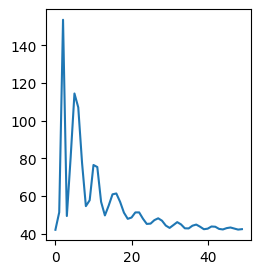

In [84]:
plt.figure(figsize=(9,3))
ax=plt.subplot(131)
ax.plot(history["losses"])
ax.set_title("alpha = {}".format(alpha))

In [224]:
history["losses"]

[2739.5009765625, 2739.61669921875, 2739.026611328125]

In [92]:
params_evol = np.stack(history["params"])

In [93]:
params_evol.shape

(50, 4, 2)

In [102]:
params_evol[-1,:,:]

array([[-9.84548405e-02, -2.00199389e+00],
       [ 1.99888539e+00, -1.00867145e-01],
       [ 1.63678615e-03, -1.21878565e-03],
       [-3.93029477e-04, -2.43464019e-05]], dtype=float32)

In [ ]:
params_evol[-1,:,:]

In [103]:
params_evol[0,:,:]

array([[-9.84548405e-02, -2.00199389e+00],
       [ 1.99888539e+00, -1.00867145e-01],
       [ 1.63678615e-03, -1.21878565e-03],
       [-3.93029477e-04, -2.43464019e-05]], dtype=float32)

In [104]:
params_evol[1,:,:]

array([[-9.84548405e-02, -2.00199389e+00],
       [ 1.99888539e+00, -1.00867145e-01],
       [ 1.63678615e-03, -1.21878565e-03],
       [-3.93029477e-04, -2.43464019e-05]], dtype=float32)

In [105]:
params_evol[2,:,:]

array([[-9.84548405e-02, -2.00199389e+00],
       [ 1.99888539e+00, -1.00867145e-01],
       [ 1.63678615e-03, -1.21878565e-03],
       [-3.93029477e-04, -2.43464019e-05]], dtype=float32)

In [142]:
alpha=0.0

In [144]:
inputs_cell = [dt, None]#,  [gamma, omega, n, eta, kappa, b], 3*omega]

RNN = RecurrentNetwork(inputs_cell)

optimizer = torch.optim.Adam(list(RNN.parameters()), lr=1e-2)
dys = torch.rand(( len(times)-1, 2)).to(torch.device("cpu"))
history = {}
history["losses"] = []
history["params"] = []
history["gradients"] = []

for ind in range(50):
    loss = lasso_cost(dys, f_true,RNN, alpha=alpha)
    loss.backward()
    
    optimizer.step()
    history["losses"].append(loss.item())
    history["params"].append(RNN.RCell.coeffs_f.detach().numpy())
    history["gradients"].append(RNN.RCell.coeffs_f.grad.numpy())
    
    print(loss.item())
    
    optimizer.zero_grad()

2.3915194269363838e-09
160.22470092773438
13.968446731567383
83.39209747314453
58.410545349121094
10.832406044006348
15.311223983764648
36.78801727294922
45.4331169128418
33.33546447753906
11.788650512695312
1.5789989233016968
13.181295394897461
26.096006393432617
19.181339263916016
5.764366626739502
2.3499484062194824
8.296516418457031
14.557644844055176
14.443083763122559
8.178478240966797
1.8995909690856934
1.9248143434524536
7.12896728515625
9.30862045288086
5.416484355926514
1.2484279870986938
1.3805598020553589
4.196326732635498
5.638876914978027
3.9691193103790283
1.1497366428375244
0.41872698068618774
2.2136712074279785
3.4113729000091553
2.122478485107422
0.3935982584953308
0.4262501001358032
1.5988346338272095
2.008824110031128
1.0957376956939697
0.13172774016857147
0.3521777093410492
1.1449283361434937
1.1054162979125977
0.35740897059440613
0.0790608823299408
0.49814942479133606
0.8015658259391785
0.5103765726089478


In [146]:
params_evol = np.stack(history["params"])

Text(0.5, 1.0, 'alpha = 0.0')

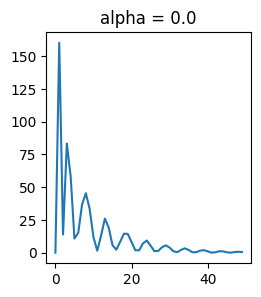

In [147]:
plt.figure(figsize=(9,3))
ax=plt.subplot(131)
ax.plot(history["losses"])
ax.set_title("alpha = {}".format(alpha))

In [148]:
params_evol[-1,:,:]

array([[-9.9779375e-02, -2.0009849e+00],
       [ 2.0000982e+00, -1.0125001e-01],
       [ 1.4825827e-03, -5.9076678e-04],
       [-3.3940680e-04, -7.0627441e-04]], dtype=float32)

In [149]:
params_evol[1,:,:]

array([[-9.9779375e-02, -2.0009849e+00],
       [ 2.0000982e+00, -1.0125001e-01],
       [ 1.4825827e-03, -5.9076678e-04],
       [-3.3940680e-04, -7.0627441e-04]], dtype=float32)

In [119]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import solve_continuous_are


class GRNN(torch.nn.Module):
    def __init__(self,inputs_cell):
        super(GRNN, self).__init__()
        self.dt = inputs_cell[0]
        omega_f, gamma_f = 2., .1
        if inputs_cell[1] is None:
            initial_data_f = [ [-gamma_f,-omega_f], [omega_f, -gamma_f], [0., 0.], [0., 0.] ] #be careful, A-->A^T here
        else:
            initial_data_f = inputs_cell[1]
        self.coeffs_f = torch.nn.Parameter(data = torch.tensor(initial_data_f, dtype=torch.float32,
                                                                      requires_grad = True))
        
        
    def forward(self, dy, state):
        """
        input_data is dy
        hidden_state is x: (<q>, <p>, Var[x], Var[p], Cov(q,q)})
        output dy_hat
        """
        f = state

        dictionary = torch.concatenate([f, f**3])
        
        df = self.dt*dictionary.matmul(self.coeffs_f) ###Check this!
        fnew = f+ df
        
        return fnew, dy

class RecurrentNetwork(torch.nn.Module):
    def __init__(self,inputs_cell):
        super(RecurrentNetwork, self).__init__()
        self.RCell = GRNN(inputs_cell=inputs_cell)
        
    def forward(self, dys):
        dys_hat = []
        xs_hat = [torch.tensor([2., 0.], dtype=torch.float32)]
        x_hat = xs_hat[0]
        for dy_t in dys:
            x_hat, dy_hat = self.RCell(dy_t, x_hat)
            dys_hat += [dy_hat]
            xs_hat += [x_hat]
        return torch.stack(xs_hat), torch.stack(dys_hat)

In [126]:
omega_f,gamma_f = 2., .1
initial_params = [ [-2*gamma_f,-2*omega_f], [2*omega_f, -2*gamma_f], [0., 0.], [0., 0.] ]

inputs_cell = [dt, initial_params]#,  [gamma, omega, n, eta, kappa, b], 3*omega]

RNN = RecurrentNetwork(inputs_cell)

alpha = 10.
optimizer = torch.optim.Adam(list(RNN.parameters()), lr=1e-2)
dys = torch.rand(( len(times)-1, 2)).to(torch.device("cpu"))
history = {}
history["losses"] = []
history["params"] = [RNN.RCell.coeffs_f.detach().numpy()]
history["gradients"] = []

alpha = 10.
for ind in range(500):
    loss = lasso_cost(dys, f_true,RNN, alpha=alpha)
    loss.backward()
    
    optimizer.step()
    history["losses"].append(loss.item())
    history["params"].append(RNN.RCell.coeffs_f.detach().numpy())
    history["gradients"].append(RNN.RCell.coeffs_f.grad.numpy())
    
    print(loss.item())
    
    optimizer.zero_grad()

6879.3212890625
6518.763671875
6251.3359375
6043.9462890625
5877.77978515625
5741.16552734375
5626.51025390625
5528.60888671875
5443.7724609375
5369.31884765625
5303.2470703125
5244.03955078125
5190.5263671875
5141.7841796875
5097.08056640625
5055.82275390625
5017.52197265625
4981.779296875
4948.2578125
4916.67578125
4886.79052734375
4858.3984375
4831.32421875
4805.41162109375
4780.5302734375
4756.56201171875
4733.40576171875
4710.970703125
4689.17724609375
4667.95361328125
4647.2373046875
4626.9716796875
4607.10498046875
4587.59228515625
4568.39208984375
4549.4677734375
4530.7841796875
4512.31103515625
4494.021484375
4475.888671875
4457.88916015625
4440.00146484375
4422.2060546875
4404.48486328125
4386.8203125
4369.197265625
4351.60009765625
4334.0146484375
4316.4306640625
4298.83349609375
4281.21240234375
4263.55810546875
4245.85888671875
4228.1044921875
4210.287109375
4192.3984375
4174.42919921875
4156.37109375
4138.2177734375
4119.9609375
4101.59375
4083.10986328125
4064.5017089843

46.98512268066406
46.9672966003418
46.94938659667969
46.93159484863281
46.91376495361328
46.896148681640625
46.878475189208984
46.86070251464844
46.843448638916016
46.82587432861328
46.80820846557617
46.79098129272461
46.77348709106445
46.75595474243164
46.73873519897461
46.721519470214844
46.70438766479492
46.68721008300781
46.669960021972656
46.65290832519531
46.635868072509766
46.618812561035156
46.60188293457031
46.5849494934082
46.568145751953125
46.55128479003906
46.53464889526367
46.517982482910156
46.501285552978516
46.484596252441406
46.46803283691406
46.45137023925781
46.43511199951172
46.41863250732422


Text(0.5, 1.0, 'alpha = 10.0')

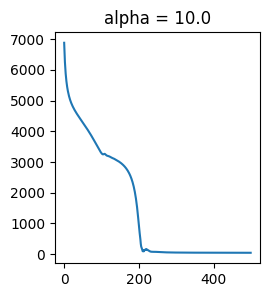

In [127]:
plt.figure(figsize=(9,3))
ax=plt.subplot(131)
ax.plot(history["losses"])
ax.set_title("alpha = {}".format(alpha))

In [129]:
params_evol = np.stack(history["params"])

In [131]:
params_evol = np.stack(history["params"])
print(params_evol[0,:,:])
print(params_evol[-1,:,:])

array([[-1.0073173e-01, -1.8302536e+00],
       [ 2.1763725e+00, -9.9489436e-02],
       [ 7.8547723e-04, -7.5506426e-02],
       [-8.1949241e-02, -5.5627488e-06]], dtype=float32)

In [130]:
params_evol[0,:,:]

array([[-1.0073173e-01, -1.8302536e+00],
       [ 2.1763725e+00, -9.9489436e-02],
       [ 7.8547723e-04, -7.5506426e-02],
       [-8.1949241e-02, -5.5627488e-06]], dtype=float32)

In [136]:
f_hat, dys_hat = RNN(dys)
f_hat = f_hat.detach().numpy()

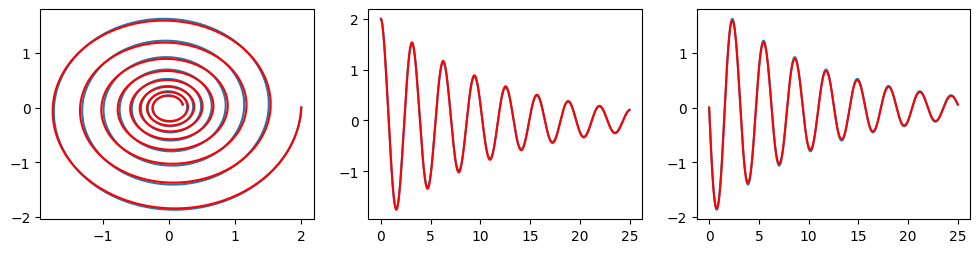

In [141]:
plt.figure(figsize=(12,6))
ax = plt.subplot(231)
ax.plot(xx1[0,:], xx1[1,:])
ax.plot(f_hat[:,0], f_hat[:,1], color="red")

ax = plt.subplot(232)
ax.plot(times, xx1[0,:])
ax.plot(times, f_hat[:,0], color="red")

ax = plt.subplot(233)
ax.plot(times, xx1[1,:])
ax.plot(times, f_hat[:,1], color="red")


### optimization a bit more difficult, having all parameters initialized differently

In [156]:
omega_f,gamma_f = 2., .1
initial_params = [ [-2*gamma_f,-2*omega_f], [2*omega_f, -2*gamma_f], [-2*gamma_f,-2*omega_f], [2*omega_f, -2*gamma_f] ]

inputs_cell = [dt, initial_params]#,  [gamma, omega, n, eta, kappa, b], 3*omega]

RNN = RecurrentNetwork(inputs_cell)

alpha = 10.
optimizer = torch.optim.Adam(list(RNN.parameters()), lr=1e-2)
dys = torch.rand(( len(times)-1, 2)).to(torch.device("cpu"))
history = {}
history["losses"] = []
history["params"] = [RNN.RCell.coeffs_f.detach().numpy()]
history["gradients"] = []

alpha = 10.
for ind in range(500):
    loss = lasso_cost(dys, f_true,RNN, alpha=alpha)
    loss.backward()
    
    optimizer.step()
    history["losses"].append(loss.item())
    history["params"].append(RNN.RCell.coeffs_f.detach().numpy())
    history["gradients"].append(RNN.RCell.coeffs_f.grad.numpy())
    
    print(loss.item())
    
    optimizer.zero_grad()

6492.0791015625
6292.32470703125
6135.39111328125
6009.22998046875
5906.435546875
5819.85498046875
5746.06689453125
5682.83935546875
5628.11669921875
5580.20556640625
5537.86572265625
5500.19677734375
5466.50537109375
5436.224609375
5408.87744140625
5384.0625
5361.43994140625
5340.7265625
5321.69189453125
5304.1416015625
5287.9140625
5272.87353515625
5258.90576171875
5245.9091796875
5233.7958984375
5222.49072265625
5211.92041015625
5202.02294921875
5192.7412109375
5184.01953125
5175.81298828125
5168.07373046875
5160.76318359375
5153.84228515625
5147.27734375
5141.0361328125
5135.08984375
5129.41064453125
5123.9755859375
5118.7607421875
5113.748046875
5108.91796875
5104.2529296875
5099.73828125
5095.35986328125
5091.10302734375
5086.9599609375
5082.9169921875
5078.96533203125
5075.09619140625
5071.3017578125
5067.57470703125
5063.90869140625
5060.296875
5056.73583984375
5053.21875
5049.74169921875
5046.30078125
5042.89306640625
5039.5146484375
5036.16357421875
5032.83642578125
5029.5322

In [157]:
params_evol = np.stack(history["params"])
print(params_evol[0,:,:])
print("\n")
print(params_evol[-1,:,:])

[[ 0.16063935 -1.1341791 ]
 [ 1.0799567   0.15946116]
 [-0.83252054 -4.110235  ]
 [ 4.090174   -0.79979897]]


[[ 0.16063935 -1.1341791 ]
 [ 1.0799567   0.15946116]
 [-0.83252054 -4.110235  ]
 [ 4.090174   -0.79979897]]


Text(0.5, 1.0, 'alpha = 10.0')

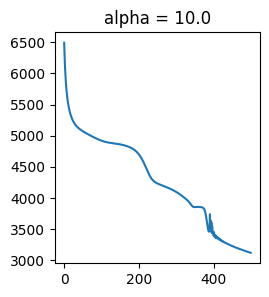

In [158]:
plt.figure(figsize=(9,3))
ax=plt.subplot(131)
ax.plot(history["losses"])
ax.set_title("alpha = {}".format(alpha))

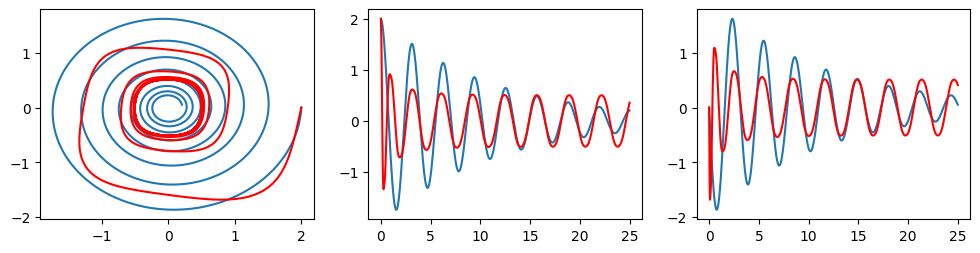

In [159]:
f_hat, dys_hat = RNN(dys)
f_hat = f_hat.detach().numpy()

plt.figure(figsize=(12,6))
ax = plt.subplot(231)
ax.plot(xx1[0,:], xx1[1,:])
ax.plot(f_hat[:,0], f_hat[:,1], color="red")

ax = plt.subplot(232)
ax.plot(times, xx1[0,:])
ax.plot(times, f_hat[:,0], color="red")

ax = plt.subplot(233)
ax.plot(times, xx1[1,:])
ax.plot(times, f_hat[:,1], color="red")
